In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import cv2
device = torch.device('cpu')
from torchvision.models import efficientnet_b0

In [3]:
class PipeNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = efficientnet_b0(weights='DEFAULT').features
        for param in self.backbone.parameters():
            param.requires_grad = False
        for param in self.backbone[-1].parameters():
            param.requires_grad = True
            
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            nn.Linear(1280, 320),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        self.missing_head = nn.Linear(320, 4*10)
        self.oxide_head = nn.Linear(320, 4*10)
        self.odd_head = nn.Linear(320, 4*10)

    def forward(self, x):
        x = self.pool(self.backbone(x)).flatten(1)
        x = self.head(x)
        return {
            "missing": self.missing_head(x).view(-1, 4, 10),
            "oxide": self.oxide_head(x).view(-1, 4, 10),
            "odd": self.odd_head(x).view(-1, 4, 10)
        }


model = PipeNetwork()
model.load_state_dict(torch.load(f'./data/checkpoints/pipe_detector.pth'))
model.to(device)

PipeNetwork(
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivati

missing: tensor([[[1., 0., 1., 1., 1., 0., 1., 1., 0., 1.],
         [1., 1., 1., 1., 1., 0., 1., 1., 0., 1.],
         [1., 1., 1., 1., 1., 0., 1., 1., 0., 1.],
         [1., 1., 1., 1., 1., 0., 1., 1., 0., 1.]]], grad_fn=<RoundBackward0>)
oxide: tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]]], grad_fn=<RoundBackward0>)
odd: tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], grad_fn=<RoundBackward0>)


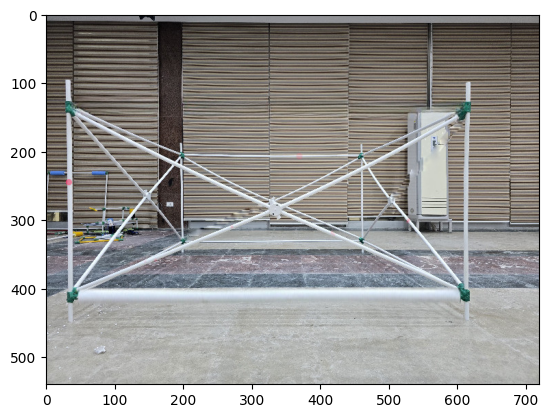

In [4]:
model.eval()

transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

img = Image.open('./data/test/26.jpeg').convert("RGB")
img_t = transform(img).unsqueeze(0)

result = model(img_t)

print(f'missing: {torch.sigmoid(result['missing']).round()}')
print(f'oxide: {torch.sigmoid(result['oxide']).round()}')
print(f'odd: {torch.sigmoid(result['odd']).round()}')
plt.imshow(img)